# Download wave data
In this notebook, we extract wave data for the area of interest, from different reanalyses. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import copernicusmarine
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import Stamen
from astropy.time import Time, TimeDelta
import pandas as pd
import geopandas as gpd
from coastsat import SDS_tools
from datetime import datetime

## Copernicus Marine Service
the Copernicus Marine Service. We use the `GLOBAL_REANALYSIS_WAV_001_032` product from COPERNICUS, which describes past sea states from 15/01/1993 to 30/04/2023. To get this data, register at [Copernicus Marine Service](https://data.marine.copernicus.eu/).

> Data: [https://doi.org/10.48670/moi-00022](https://doi.org/10.48670/moi-00022)

> Law-Chune, S., Aouf, L., Dalphinet, A. et al. "WAVERYS: a CMEMS global wave reanalysis during the altimetry period". Ocean Dynamics 71, 357–378 (2021). [https://doi.org/10.1007/s10236-020-01433-w](https://doi.org/10.1007/s10236-020-01433-w)

## Area of Interest
The user must define the Area Of Interest (AOI) in lat/lon coordinates. The script calculates automatically the center of the bounding box, that will be then used to extract wave and tide timeseries. To define the bounding box, you can use this website: http://bboxfinder.com 

The user is also asked to insert the coordinates of a Site of Interest (SOI).

In [2]:
from coastsat.CsatVe_select_folder import select_folder
# Call the function to select a folder and create additional folders for Waves
sitename_container = select_folder(create_additional_folders=True)
sitename = sitename_container["value"]
if sitename:
    print(f"The selected folder name is: {sitename}")
else:
    print("No folder was selected.")

No folder was selected.


Now, we import the data that was produced in the first two steps (`Calculate_Tide` and `Extract_Shorelines`).

In [3]:
sitename = sitename_container["value"]
data_folder_path = "Data"

# Construct the full file path for the CSV file
csv_file_path = os.path.join(data_folder_path, sitename, "water_levels", f"FES2022_location_date_{sitename}.csv")

# Construct the full file path for the GeoJSON file
geojson_file_path = os.path.join(data_folder_path, sitename, "Output", "data", "ROI_satellite.geojson")

# Load the CSV file
if os.path.exists(csv_file_path):
    water_levels_df = pd.read_csv(csv_file_path)
    print(f"Successfully loaded the location file")

    # Extract LAT and LON into the tidal_point list
    tidal_point = [water_levels_df.iloc[0]["LAT"], water_levels_df.iloc[0]["LON"]]

    # Extract START_DATE and END_DATE into the dates list
    dates = [
        water_levels_df.iloc[0]["START_DATE"].split("T")[0],
        water_levels_df.iloc[0]["END_DATE"].split("T")[0],
    ]

    # Print results
    print("Tidal Point (LAT, LON):", tidal_point)
    print("Dates (START_DATE, END_DATE):", dates)
else:
    print(f"File not found: {csv_file_path}")

# Load the GeoJSON file
if os.path.exists(geojson_file_path):
    gdf = gpd.read_file(geojson_file_path)
    print(f"Successfully loaded the GeoJSON file: {geojson_file_path}")
    
    # Optional: Inspect the GeoDataFrame
    print(gdf.head())
else:
    print(f"File not found: {geojson_file_path}")
    gdf = gpd.GeoDataFrame()  # Create an empty GeoDataFrame to avoid errors later

Successfully loaded the location file
Tidal Point (LAT, LON): [-46.53715579888858, -67.441463470459]
Dates (START_DATE, END_DATE): ['1980-01-01', '2024-10-31']
Successfully loaded the GeoJSON file: Data/Caleta_Olivia/Output/data/ROI_satellite.geojson
                                            geometry
0  POLYGON ((-67.45155 -46.53365, -67.44769 -46.5...


Now, select the area of interest (AOI) where wave data should be extracted. The virtual buoy will be located at the center of the AOI.

In [4]:
import os
import folium
from folium import plugins
from IPython.display import display, Markdown
import geopandas as gpd

# Specify the directory where you want to save the exported GeoJSON file
output_dir = os.path.join('Data', sitename, 'Waves', 'data')  # Replace with your desired directory

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Create a map centered around a specific location
m = folium.Map(location=tidal_point, zoom_start=12)

# Add a tile layer with satellite imagery
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Satellite',
    overlay=False,
    control=True
).add_to(m)

# Add the tidal point to the map
folium.CircleMarker(
    location=tidal_point,
    radius=5,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=1,
    weight=2,
    opacity=1,
).add_to(m)

folium.Marker(
    tidal_point,
    popup="point of tidal data extraction",
    icon=folium.Icon(color="black", icon="info-sign")
).add_to(m)

# Add draw plugin to the map, specifying the output directory
draw = plugins.Draw(export=True, filename="AOI_Waves.geojson", position="topleft")  # filename added and position changed for better visibility
draw.add_to(m)

# Construct the full path to the output file
output_file = os.path.join(output_dir, "AOI_Waves.geojson")


if os.path.exists(geojson_file_path):
    # Load the GeoJSON file
    gdf = gpd.read_file(geojson_file_path)
    if not gdf.empty:
        # Add the polygon to the map as an outline
        folium.GeoJson(
            gdf,
            name="ROI of satellite imagery extraction",
            style_function=lambda x: {
                "color": "blue",
                "weight": 2,
                "fillOpacity": 0
            },
            tooltip="ROI of satellite imagery extraction"
        ).add_to(m)
        print("GeoJSON file loaded and added to the map.")
    else:
        print("GeoJSON file exists but is empty.")
else:
    print(f"GeoJSON file not found at: {geojson_file_path}")

# Display the instructions to the user
display(Markdown(
    f"After exporting the file, please move it to the directory: `{output_dir}` and make sure its name is `AOI_Waves`."
))

# Display the map
m

GeoJSON file loaded and added to the map.


After exporting the file, please move it to the directory: `Data/Caleta_Olivia/Waves/data` and make sure its name is `AOI_Waves`.

In [5]:
# Load the polygon from the GeoJSON file
geojson_polygon = os.path.join(os.getcwd(), output_dir, 'AOI_Waves.geojson')

if not os.path.exists(geojson_polygon):
    raise FileNotFoundError(f"GeoJSON file not found at: {geojson_polygon}")

# load from .geojson
polygon = SDS_tools.polygon_from_geojson(geojson_polygon)

# Original dates list
dates = ['1980-01-01', '2024-10-31']

# Extract start and end dates from the list
start_date = dates[0]
end_date = dates[1]

# Format start and end datetime variables
start_datetime = f"{start_date}T00:00:00"
end_datetime = f"{end_date}T23:59:59"

# Print the results
print("Start datetime:", start_datetime)
print("End datetime:", end_datetime)

# Flatten the coordinates list
coordinates = polygon[0]  # Access the inner list containing the coordinates

# Extract longitudes and latitudes
longitudes = [coord[0] for coord in coordinates]
latitudes = [coord[1] for coord in coordinates]

# Calculate bounding box
minimum_longitude = min(longitudes)
maximum_longitude = max(longitudes)
minimum_latitude = min(latitudes)
maximum_latitude = max(latitudes)

# Calculate the center of the bounding box
center_longitude = (minimum_longitude + maximum_longitude) / 2
center_latitude = (minimum_latitude + maximum_latitude) / 2

print("minimum_longitude =", minimum_longitude)
print("maximum_longitude =", maximum_longitude)
print("minimum_latitude =", minimum_latitude)
print("maximum_latitude =", maximum_latitude)
print("Center Longitude:", center_longitude)
print("Center Latitude:", center_latitude)

output_filename=sitename+'_GLOBAL_REANALYSIS_WAV_001_032.nc'

Start datetime: 1980-01-01T00:00:00
End datetime: 2024-10-31T23:59:59
minimum_longitude = -68.093262
maximum_longitude = -60.776367
minimum_latitude = -47.886881
maximum_latitude = -44.087585
Center Longitude: -64.4348145
Center Latitude: -45.987233


We then plot the AOI and the site on a map, to check that everthing was done correctly before wave extraction.

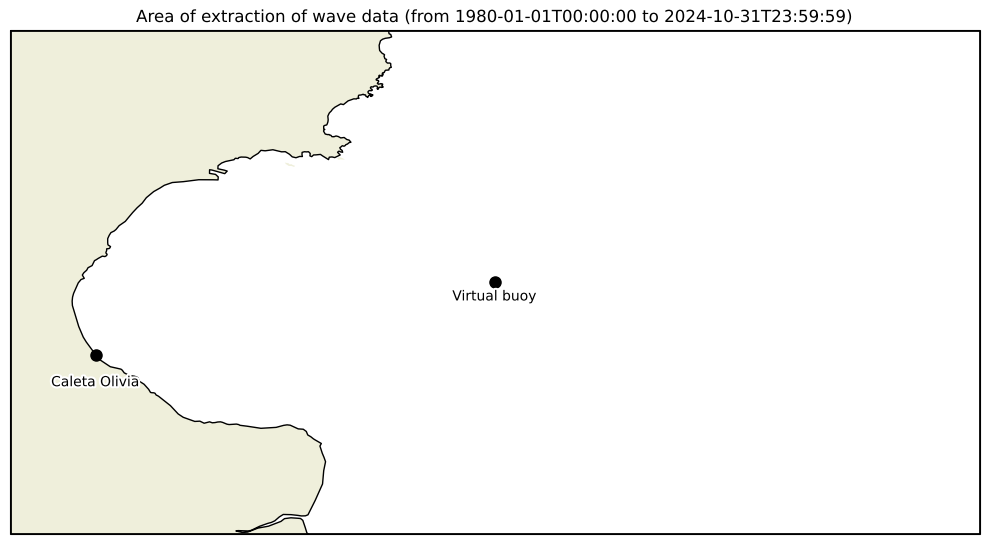

In [6]:
from cartopy.feature import ShapelyFeature
from matplotlib.patheffects import withStroke

# Specify the directory where you want to save the exported GeoJSON file
img_dir = os.path.join('Data', sitename, 'Waves', 'img')  # Replace with your desired directory

# Define the text outline effect
outline_effect = [withStroke(linewidth=3, foreground="white")]

# Set up the map with PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([min(longitudes) - 1, max(longitudes) + 1, min(latitudes) - 1, max(latitudes) + 1], crs=ccrs.PlateCarree())

# Plot the center of the polygon and the SOI
ax.plot(center_longitude, center_latitude, marker='o', color='k', markersize=8, transform=ccrs.PlateCarree())
ax.text(
    center_longitude + center_longitude * 0.5 / 100, 
    center_latitude + center_latitude * 0.3 / 100, 
    'Virtual buoy', 
    color='k', 
    transform=ccrs.PlateCarree(),
    path_effects=outline_effect
)

# Add high-resolution features
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':')

# Plot the polygon for wave extraction
ax.plot(longitudes + [longitudes[0]], latitudes + [latitudes[0]], color='k', linewidth=2, transform=ccrs.PlateCarree())

if not gdf.empty:
    roi_polygon = gdf.geometry.iloc[0]
    roi_centroid = roi_polygon.centroid

    # Plot the center of the ROI polygon as a dot
    ax.plot(
        roi_centroid.x, roi_centroid.y, 
        marker='o', color='k', markersize=8, transform=ccrs.PlateCarree()
    )
    ax.text(
        roi_centroid.x + roi_centroid.x * 0.5 / 100,
        roi_centroid.y + roi_centroid.y * 0.5 / 100,
        sitename.replace("_", " "),
        color="k",
        fontsize=10,
        transform=ccrs.PlateCarree(),
        path_effects=outline_effect
    )

# Set extent to focus on the polygon area
ax.set_extent([min(longitudes), max(longitudes), min(latitudes), max(latitudes)], crs=ccrs.PlateCarree())

# Add title with date range
ax.set_title(
    f"Area of extraction of wave data (from {start_datetime} to {end_datetime})", 
    fontsize=12,
    path_effects=outline_effect
)

# Save the 
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'Wave_Extraction_Area.jpg'), dpi=300, bbox_inches='tight')
plt.show()

Now, we can start extracting wave data. First, we need to make sure to insert the login credentials to the Copernicus Marine Services.
**This needs to be run only the first time you run this script, the user and passord are saved into the system.**

In [ ]:
# Unocmment the first time you use the script
#copernicusmarine.login()

Next, we interrogate the Copernicus dataset to download wave data from 1994 to 2021. We extract the following attributes:

1. **VHM0 [m]** - Spectral significant wave height (Hm0)
2. **VTPK [s]** - Wave period at spectral peak / peak period (Tp)
3. **VMDR [degree]** - Mean wave direction (Mdir)

Querying and downloading this data might take some time, so please be patient.

In [7]:
copernicusmarine.subset(
  dataset_id="cmems_mod_glo_wav_my_0.2deg_PT3H-i",
  minimum_longitude=minimum_longitude,
  maximum_longitude=maximum_longitude,
  minimum_latitude=minimum_latitude,
  maximum_latitude=maximum_latitude,
  start_datetime=start_date,
  end_datetime=end_date,
  output_filename = output_filename,
  output_directory = output_dir)

INFO - 2024-12-23T10:30:54Z - Dataset version was not specified, the latest one was selected: "202411"
INFO - 2024-12-23T10:30:54Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-12-23T10:30:56Z - Service was not specified, the default one was selected: "arco-time-series"
WARNING - 2024-12-23T10:30:57Z - Some or all of your subset selection [1980-01-01 00:00:00, 2024-10-31 00:00:00] for the time dimension  exceed the dataset coordinates [1980-01-01 00:00:00, 2023-04-30 21:00:00]
INFO - 2024-12-23T10:30:57Z - Downloading using service arco-time-series...
INFO - 2024-12-23T10:30:59Z - <xarray.Dataset> Size: 4GB
Dimensions:    (time: 126608, latitude: 13, longitude: 16)
Coordinates:
  * latitude   (latitude) float32 52B 28.0 28.2 28.4 28.6 ... 30.0 30.2 30.4
  * longitude  (longitude) float32 64B -86.6 -86.4 -86.2 ... -84.0 -83.8 -83.6
  * time       (time) datetime64[ns] 1MB 1980-01-01 ... 2023-04-30T21:00:00
Data variables: (12/17)
    VHM0       (tim

  y


INFO - 2024-12-23T10:31:06Z - Writing to local storage. Please wait...


  0%|          | 0/11154 [00:00<?, ?it/s]

INFO - 2024-12-23T10:35:32Z - Successfully downloaded to Data/Alpachicola/Waves/data/Alpachicola_GLOBAL_REANALYSIS_WAV_001_032.nc


PosixPath('Data/Alpachicola/Waves/data/Alpachicola_GLOBAL_REANALYSIS_WAV_001_032.nc')

The next step is to extract a timeseries from the netcdf file that contains wave data and transforming it into a pandas dataframe.

In [7]:
wav_nc = os.path.join(output_dir,output_filename)
wav_ds = xr.open_dataset(wav_nc)
wav_ds

# Select the data at the specified location
location_data = wav_ds.sel(latitude=center_latitude, longitude=center_longitude, method='nearest')

# Extract the variables you're interested in
variables = ['VHM0', 'VTPK', 'VMDR']
location_data = location_data[variables]

# Convert the xarray dataset to a Pandas DataFrame
waves_df = location_data.to_dataframe().reset_index().drop(['latitude', 'longitude'], axis=1)
wav_ds

<xarray.Dataset> Size: 12GB
Dimensions:    (time: 126608, latitude: 19, longitude: 37)
Coordinates:
  * latitude   (latitude) float32 76B -47.8 -47.6 -47.4 ... -44.6 -44.4 -44.2
  * longitude  (longitude) float32 148B -68.0 -67.8 -67.6 ... -61.2 -61.0 -60.8
  * time       (time) datetime64[ns] 1MB 1980-01-01 ... 2023-04-30T21:00:00
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float64 712MB ...
    VHM0_SW1   (time, latitude, longitude) float64 712MB ...
    VHM0_SW2   (time, latitude, longitude) float64 712MB ...
    VHM0_WW    (time, latitude, longitude) float64 712MB ...
    VMDR       (time, latitude, longitude) float64 712MB ...
    VMDR_SW1   (time, latitude, longitude) float64 712MB ...
    ...         ...
    VTM01_SW1  (time, latitude, longitude) float64 712MB ...
    VTM01_SW2  (time, latitude, longitude) float64 712MB ...
    VTM01_WW   (time, latitude, longitude) float64 712MB ...
    VTM02      (time, latitude, longitude) float64 712MB ...
    VTM10      (time, latitude, longitude) float64 712MB ...
    VTPK       (time, latitude, longitude) float64 712MB ...
Attributes: (12/31)
    CDI:                           Climate Data Interface version 1.9.8 (http...
    CDO:                           Climate Data Operators version 1.9.8 (http...
    Conventions:                   CF-1.6
    area:                          GLO
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    references:                    http://marine.copernicus.eu
    time_coverage_end:             20230430-21:00:00
    time_coverage_start:           20230430-00:00:00
    title:                         Mean fields from global wave model MFWAM o...
    version:                       1.2
    copernicusmarine_version:      1.3.4

Next, the data is plotted to make sure there are no outliers or errors.

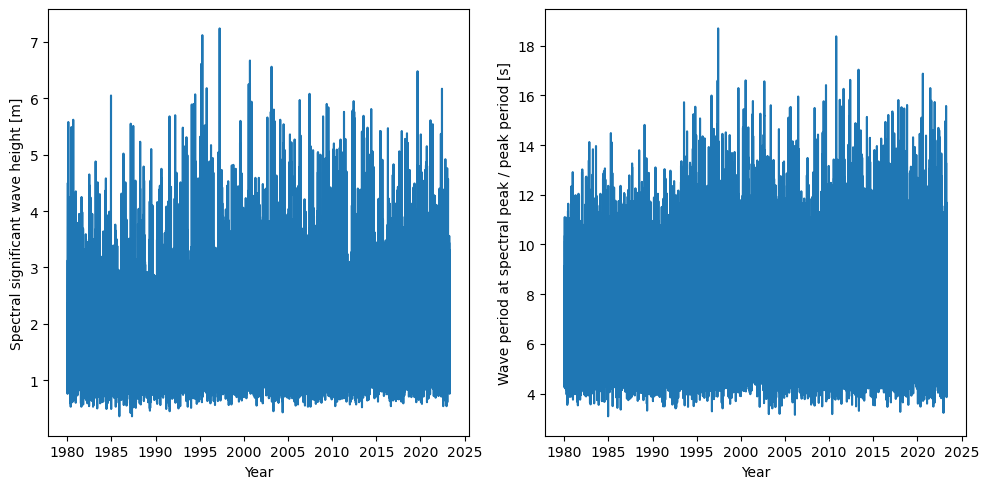

In [8]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(waves_df['time'], waves_df['VHM0'], label='VHM0')
axes[0].set_ylabel('Spectral significant wave height [m]')
axes[0].set_xlabel('Year')
axes[1].plot(waves_df['time'], waves_df['VTPK'], label='VTPK')
axes[1].set_ylabel('Wave period at spectral peak / peak period [s]')
axes[1].set_xlabel('Year')

plt.tight_layout()
plt.savefig(os.path.join(img_dir,'Hs_Tp_timeseries.jpg'),dpi=300,bbox_inches='tight')
plt.show()

Next, a wave rose is plotted on top of a geographic map, to show provenance of main waves.

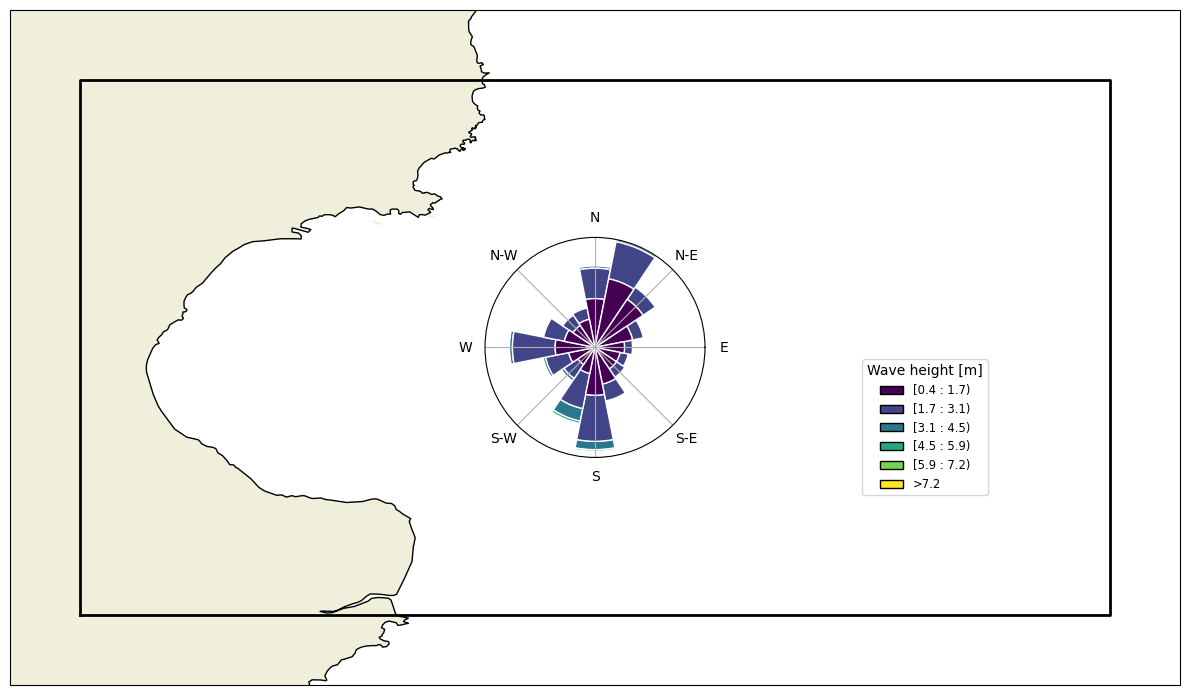

In [9]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from windrose import WindroseAxes
from matplotlib import cm

center_longitude = (min(longitudes) + max(longitudes)) / 2
center_latitude = (min(latitudes) + max(latitudes)) / 2

# Map extent coordinates (from your polygon)
minlon, maxlon = min(longitudes) - 0.5, max(longitudes) + 0.5
minlat, maxlat = min(latitudes) - 0.5, max(latitudes) + 0.5

# Set up the map with PlateCarree projection
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 8))
main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.add_feature(cfeature.LAND.with_scale('10m'))
main_ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
main_ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':')

# Plot the polygon boundary
main_ax.plot(longitudes + [longitudes[0]], latitudes + [latitudes[0]], color='k', linewidth=2, transform=ccrs.PlateCarree())

# Plot the Site of Interest and the Virtual Buoy
#main_ax.plot(lon_SOI, lat_SOI, marker='o', color='k', markersize=9, transform=ccrs.PlateCarree(), label='Site of Interest')

# Windrose inset at the virtual buoy location
wrax = inset_axes(
    main_ax,
    width=2.2,  # size in inches
    height=2.2,  # size in inches
    loc="center",
    bbox_to_anchor=(center_longitude, center_latitude),
    bbox_transform=main_ax.transData,
    axes_class=WindroseAxes,
)

# Plot windrose data (wave direction and wave height)
wrax.bar(waves_df['VMDR'], waves_df['VHM0'], normed=True, opening=1, edgecolor='white',nsector=16,calm_limit=0.3)

# Move the windrose legend to the right of the main map
legend_ax = fig.add_axes([0.75, 0.52, 0.05, 0.4])  # Position: [left, bottom, width, height]
wrax.legend(title='Wave height [m]', fontsize='small', loc='center', bbox_to_anchor=(0.5, -0.3), bbox_transform=legend_ax.transAxes)
legend_ax.axis('off')  # Hide the extra axis itself
wrax.set_yticks([])  # Turn off percentage labels

# Save and display the figure
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'Map_with_Windrose_Buoy.jpg'), dpi=300, transparent=True,bbox_inches='tight')
plt.show()

## Filter and plot wave data
After the wave data are downloaded, we build a second dataframe filtering those that are not oriented towards the shoreline for the sucvcessive runup analysis. Therefore, we first define the angle hereafter.

In [14]:
# Define the range of wave directions to filter
direction_min, direction_max = 30, 150  # Example range: 90°–180°
filtered_df = waves_df[(waves_df['VMDR'] >= direction_min) & (waves_df['VMDR'] <= direction_max)]

Then, wave statistics are plotted for the filtered and unfiltered data.

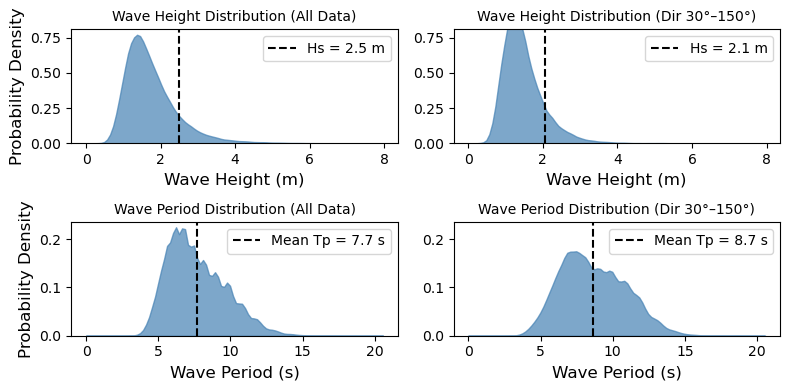

In [22]:
from scipy.stats import gaussian_kde
# Prepare data
wave_heights = waves_df['VHM0'].dropna()
wave_periods = waves_df['VTPK'].dropna()
filtered_wave_heights = filtered_df['VHM0'].dropna()
filtered_wave_periods = filtered_df['VTPK'].dropna()

# Calculate significant wave height (H1/3) for all waves
H_sorted = np.sort(wave_heights)
H1_3 = H_sorted[-int(len(H_sorted) * 1 / 3):].mean()

# Calculate peak wave period for all waves
peak_period = wave_periods.mean()

# Calculate significant wave height (H1/3) for all waves
filtered_H_sorted = np.sort(filtered_wave_heights)
filtered_H1_3 = filtered_H_sorted[-int(len(filtered_H_sorted) * 1 / 3):].mean()

# Calculate peak wave period for all waves
filtered_peak_period = filtered_wave_periods.mean()

# Set up the KDE for all and filtered data
kde_wave_heights = gaussian_kde(wave_heights)
kde_wave_periods = gaussian_kde(wave_periods)
kde_filtered_heights = gaussian_kde(filtered_wave_heights)
kde_filtered_periods = gaussian_kde(filtered_wave_periods)

# Define a common x-axis range for KDE plots
x_wave_heights = np.linspace(0, max(wave_heights.max(), filtered_wave_heights.max()) * 1.1, 100)
x_wave_periods = np.linspace(0, max(wave_periods.max(), filtered_wave_periods.max()) * 1.1, 100)

# Create a 2x2 subplot figure without shared y-axis initially
fig, axes = plt.subplots(2, 2, figsize=(8, 4), sharex=False, sharey=False)

# Manually share the y-axis for each row
for col in range(2):  # Iterate over columns
    axes[0, col].sharey(axes[0, 0])  # First row shares y-axis
    axes[1, col].sharey(axes[1, 0])  # Second row shares y-axis

# Plot KDE for wave height (All Data)
axes[0, 0].fill_between(x_wave_heights, kde_wave_heights(x_wave_heights), color='steelblue', alpha=0.7)
axes[0, 0].axvline(H1_3, color='k', linestyle='--', label=f'Hs = {H1_3:.1f} m')
axes[0, 0].set_title('Wave Height Distribution (All Data)', fontsize=10)
axes[0, 0].set_xlabel('Wave Height (m)', fontsize=12)
axes[0, 0].set_ylabel('Probability Density', fontsize=12)
axes[0, 0].set_ylim(0, None)
axes[0, 0].legend(fontsize=10)

# Plot KDE for wave height (Filtered Data)
axes[0, 1].fill_between(x_wave_heights, kde_filtered_heights(x_wave_heights), color='steelblue', alpha=0.7)
axes[0, 1].axvline(filtered_H1_3, color='k', linestyle='--', label=f'Hs = {filtered_H1_3:.1f} m')
axes[0, 1].set_title(f'Wave Height Distribution (Dir {direction_min}°–{direction_max}°)', fontsize=10)
axes[0, 1].set_xlabel('Wave Height (m)', fontsize=12)
axes[0, 1].legend(fontsize=10)

# Plot KDE for wave period (All Data)
axes[1, 0].fill_between(x_wave_periods, kde_wave_periods(x_wave_periods), color='steelblue', alpha=0.7)
axes[1, 0].axvline(peak_period, color='k', linestyle='--', label=f'Mean Tp = {peak_period:.1f} s')
axes[1, 0].set_title('Wave Period Distribution (All Data)', fontsize=10)
axes[1, 0].set_ylabel('Probability Density', fontsize=12)
axes[1, 0].set_ylim(0, None)
axes[1, 0].set_xlabel('Wave Period (s)', fontsize=12)
axes[1, 0].legend(fontsize=10)

# Plot KDE for wave period (Filtered Data)
axes[1, 1].fill_between(x_wave_periods, kde_filtered_periods(x_wave_periods), color='steelblue', alpha=0.7)
axes[1, 1].axvline(filtered_peak_period, color='k', linestyle='--', label=f'Mean Tp = {filtered_peak_period:.1f} s')
axes[1, 1].set_title(f'Wave Period Distribution (Dir {direction_min}°–{direction_max}°)', fontsize=10)
axes[1, 1].set_xlabel('Wave Period (s)', fontsize=12)
axes[1, 1].legend(fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'Wave_Height_and_Period_KDE_Filtered_Filled.jpg'), dpi=300,bbox_inches='tight')
plt.show()

Then, we first plot the wave rose for both filtered and non-filtered wave data, and then we plot the average wave heights, periods and directions are plotted from the netcdf dataframe. 

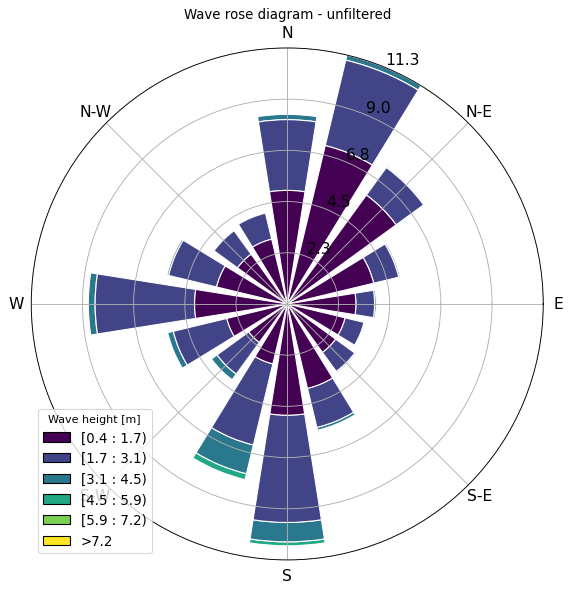

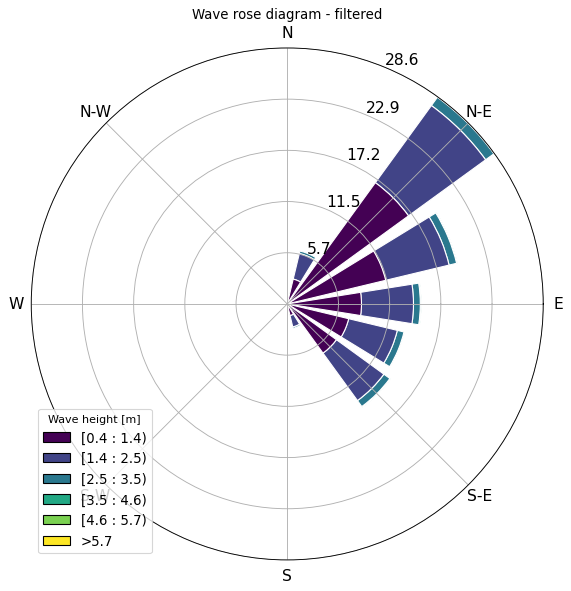

In [18]:
ax = WindroseAxes.from_ax()
ax.bar(waves_df['VMDR'], waves_df['VHM0'], normed=True, opening=0.8, edgecolor='white')
ax.legend(title='Wave height [m]', fontsize='large')
ax.tick_params(axis='x', labelsize=14)  # Adjust the font size as needed
ax.tick_params(axis='y', labelsize=14)  # Adjust the font size as needed
plt.title ("Wave rose diagram - unfiltered")
plt.savefig(os.path.join(img_dir,'Windrose_HS_unfiltered.pdf'),transparent=True,dpi=300)
plt.show()

ax = WindroseAxes.from_ax()
ax.bar(filtered_df['VMDR'], filtered_df['VHM0'], normed=True, opening=0.8, edgecolor='white')
ax.legend(title='Wave height [m]', fontsize='large')
ax.tick_params(axis='x', labelsize=14)  # Adjust the font size as needed
ax.tick_params(axis='y', labelsize=14)  # Adjust the font size as needed
plt.title ("Wave rose diagram - filtered")
plt.savefig(os.path.join(img_dir,'Windrose_HS_filtered.pdf'),transparent=True,dpi=300)
plt.show()

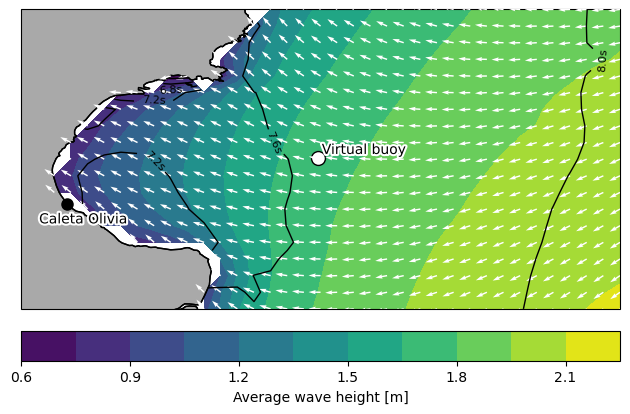

In [19]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from matplotlib.patheffects import withStroke

# Define a text outline effect
outline_effect = [withStroke(linewidth=3, foreground="white")]

# Calculate the average of the variables
average_VHM0 = wav_ds['VHM0'].mean(dim='time')
average_VMDR = wav_ds['VMDR'].mean(dim='time')
average_VTPK = wav_ds['VTPK'].mean(dim='time')

# Create grid for wave direction
lon, lat = np.meshgrid(average_VHM0.longitude, average_VHM0.latitude)
u = np.cos(np.radians(average_VMDR))  # U component of wave direction
v = np.sin(np.radians(average_VMDR))  # V component of wave direction

# Create a map using Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([average_VHM0.longitude.min(), average_VHM0.longitude.max(),
               average_VHM0.latitude.min(), average_VHM0.latitude.max()])

# Add land and coastline features
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='darkgray', zorder=2)
ax.add_feature(cfeature.COASTLINE, zorder=2)


# Plot the average wave height as a smooth contour
contour = ax.contourf(average_VHM0.longitude, average_VHM0.latitude, average_VHM0,
                      cmap='viridis', transform=ccrs.PlateCarree(), levels=10, zorder=1)

# Add wave direction arrows (white arrows for clarity)
ax.quiver(lon, lat, u, v, color='white', scale=50, transform=ccrs.PlateCarree(), zorder=3)

# Plot mean peak wave period (VTPK) as contours
vtpk_contours = ax.contour(average_VHM0.longitude, average_VHM0.latitude, average_VTPK,
                           levels=5, colors='black', linewidths=1, transform=ccrs.PlateCarree(), zorder=4)
ax.clabel(vtpk_contours, inline=True, fontsize=8, fmt="%.1fs")

# Plot points on map
if 'roi_polygon' in locals():  # Check if roi_polygon is defined
    roi_centroid = roi_polygon.centroid
    ax.plot(
        roi_centroid.x, roi_centroid.y, 
        marker='o', color='k', markersize=8, transform=ccrs.PlateCarree()
    )
    ax.text(
        roi_centroid.x + roi_centroid.x * 0.5 / 100,
        roi_centroid.y + roi_centroid.y * 0.5 / 100,
        sitename.replace("_", " "),
        color="k",
        fontsize=10,
        transform=ccrs.PlateCarree(),
        path_effects=outline_effect,
        zorder=6
    )

# Plot the Virtual Buoy in white with black outline
ax.plot(center_longitude, center_latitude, marker='o', markersize=10, markerfacecolor='white',
        markeredgecolor='black', markeredgewidth=1, transform=ccrs.PlateCarree())
ax.text(center_longitude + 0.05, center_latitude + 0.05, 'Virtual buoy', color='k',
        fontsize=10, path_effects=outline_effect, transform=ccrs.PlateCarree(),zorder=6)

# Add colorbar for wave height
cb = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label('Average wave height [m]')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'Wave_height_direction_period_map.jpg'), dpi=300,bbox_inches='tight')
plt.show()

## Data Export
The wave data is exported for further analysis.

In [20]:
# Create filenames with the direction range for the filtered dataset
filtered_filename = f"GLOBAL_REANALYSIS_WAV_001_032_waves_filtered_{direction_min}_{direction_max}.csv"
complete_filename = "GLOBAL_REANALYSIS_WAV_001_032_waves_all.csv"
coordinates_filename='Virtual_Buoy.csv'

# Export filtered DataFrame
filtered_df.to_csv(os.path.join(output_dir, filtered_filename), index=False)

# Export complete DataFrame
waves_df.to_csv(os.path.join(output_dir, complete_filename), index=False)

# Create a DataFrame
data = {'center_latitude': [center_latitude], 'center_longitude': [center_longitude]}
df = pd.DataFrame(data)
df.to_csv(os.path.join(output_dir, coordinates_filename), index=False)

print(f"Filtered data saved to: {filtered_filename}")
print(f"Complete data saved to: {complete_filename}")

Filtered data saved to: GLOBAL_REANALYSIS_WAV_001_032_waves_filtered_30_150.csv
Complete data saved to: GLOBAL_REANALYSIS_WAV_001_032_waves_all.csv


## Acknowledgments
This work is based on the CoasSat tool. Please give credit to the original repository if you use this work, and make sure you visit [the original repository](https://github.com/kvos/CoastSat) and cite the relevant papers:

- Vos K., Splinter K.D., Harley M.D., Simmons J.A., Turner I.L. (2019). CoastSat: a Google Earth Engine-enabled Python toolkit to extract shorelines from publicly available satellite imagery. *Environmental Modelling and Software*. 122, 104528. https://doi.org/10.1016/j.envsoft.2019.104528 (Open Access)

- Vos K., Harley M.D., Splinter K.D., Simmons J.A., Turner I.L. (2019). Sub-annual to multi-decadal shoreline variability from publicly available satellite imagery. *Coastal Engineering*. 150, 160–174. https://doi.org/10.1016/j.coastaleng.2019.04.004

- Vos K., Harley M.D., Splinter K.D., Walker A., Turner I.L. (2020). Beach slopes from satellite-derived shorelines. *Geophysical Research Letters*. 47(14). https://doi.org/10.1029/2020GL088365 (Open Access preprint [here](https://www.essoar.org/doi/10.1002/essoar.10502903.2))

- Vos, K. and Deng, W. and Harley, M. D. and Turner, I. L. and Splinter, K. D. M. (2022). Beach-face slope dataset for Australia. *Earth System Science Data*. volume 14, 3, p. 1345--1357. https://doi.org/10.5194/essd-14-1345-2022

- Vos, K., Harley, M.D., Turner, I.L. et al. Pacific shoreline erosion and accretion patterns controlled by El Niño/Southern Oscillation. *Nature Geosciences*. 16, 140–146 (2023). https://doi.org/10.1038/s41561-022-01117-8

This code uses the FES2022 Tide product, funded by CNES, produced by LEGOS, NOVELTIS and CLS and made freely available by AVISO. CNES, 2024. FES2022 (Finite Element Solution) Ocean Tide (Version 2022) [Data set]. CNES. https://doi.org/10.24400/527896/A01-2024.004

- Carrere et al., OSTST 2022: A new barotropic tide model for global ocean: FES2022,
https://doi.org/10.24400/527896/a03-2022.3287

- Florent H. Lyard, Loren Carrere, Ergane Fouchet, Mathilde Cancet, David Greenberg, Gérald Dibarboure and Nicolas Picot: “FES2022 a step towards a SWOT-compliant tidal correction”, to be submitted to Ocean Sciences.

FES22 data are used herein under the terms of the [license agreement](https://www.aviso.altimetry.fr/fileadmin/documents/data/License_Aviso.pdf)

Wave data in this code are generated using the E.U. Copernicus Marine Service Information. Data is available at this [link]( https://doi.org/10.48670/moi-00022). 

The modifications done within CoastSat.Venice were done in the framework of the WARMCOASTS project, led by A. Rovere at Ca' Foscari University of Venice. This software is part of a project that has received funding from the European Research Council (ERC) under the European Union’s Horizon 2020 research and innovation programme (Grant agreement No. ERC-StG-802414)
